In [1]:
import sys
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import pickle
import xgboost as xgb

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope
from tqdm import tqdm

In [2]:
%matplotlib inline
plt.ion()

In [3]:
# data frame to hold all data
datafile = uproot.open("/Users/patrick/Documents/MicroBooNE/CrossSections/NuePiXSec_Analysis/BDTTraining/pionProton/TrainingTree_PionProtonSeparation_FHC_Nov2023.root")["trainingTree"]

variables = (
    "isSignal",
    
    
    "trk_score",
    "trk_llr_pid_score",
    "trk_bragg_mip_max",
    "trk_bragg_pion_max",
    "trk_dEdx_trunk_max",
    "trk_daughters",
    "trk_end_spacepoints"


)

#variables = (
#    "isSignal",
#    "trk_llr_pid_score",
#    "trk2_llr_pid_score",
#    "trk3_llr_pid_score",
#    "trk_bragg_mip_max",
#    "trk2_bragg_mip_max",
#    "trk3_bragg_mip_max",
#    "trk_bragg_pion_max",
#    "trk2_bragg_pion_max",
#    "trk3_bragg_pion_max",
#    "trk_dEdx_trunk_max",
#    "trk2_dEdx_trunk_max",
#    "trk3_dEdx_trunk_max",
#    "trk_daughters",
#    "trk2_daughters",
#    "trk3_daughters",
#    "trk_end_spacepoints",
#    "trk2_end_spacepoints",
#    "trk3_end_spacepoints"
#)

df = pd.DataFrame(datafile.arrays(namedecode='utf-8', branches=variables))

# shuffle to avoid intrinsic sample being at start
df = df.sample(frac=1).reset_index(drop=True)


In [4]:
print(df.shape) 
print(df.keys())
df.head()

(43614, 8)
Index(['isSignal', 'trk_score', 'trk_llr_pid_score', 'trk_bragg_mip_max',
       'trk_bragg_pion_max', 'trk_dEdx_trunk_max', 'trk_daughters',
       'trk_end_spacepoints'],
      dtype='object')


,isSignal,trk_score,trk_llr_pid_score,trk_bragg_mip_max,trk_bragg_pion_max,trk_dEdx_trunk_max,trk_daughters,trk_end_spacepoints
0,True,0.912987,0.551913,0.094778,0.701478,2.636480,0.0,49.0
1,True,0.999904,0.956242,0.733834,0.601731,3.434228,0.0,34.0
2,False,0.775020,0.033233,0.087721,0.005670,9999.000000,1.0,38.0
3,True,0.905790,0.407922,0.217324,0.261382,0.339945,1.0,52.0
4,False,0.864986,0.367469,0.182443,0.239718,2.512052,0.0,16.0


In [5]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna()
print(df.shape) 

(43614, 8)


In [6]:
# calculate neg / pos weight
scale_weight = (df.query('isSignal == 0')).shape[0] / (df.query('isSignal == 1')).shape[0]
print(scale_weight)

0.6272666218938885


In [7]:
print((df.query('isSignal == 0')).shape[0])
print((df.query('isSignal == 1')).shape[0])

16812
26802


In [7]:
# splitting into testing and training samples
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 1)
labels_train = df_train["isSignal"]
labels_test = df_test["isSignal"]

df_train_sig = df_train.query("isSignal == True")
df_train_bkg = df_train.query("isSignal == False")
df_test_sig = df_test.query("isSignal == True")
df_test_bkg = df_test.query("isSignal == False")

In [8]:
print(df_train.shape)
print(df_test.shape)

(30529, 8)
(13085, 8)


In [9]:
# convert to DMatrix format
missing_value = 9999
bdt_vars = {
    "trk_llr_pid_score",
    "trk_score",
    "trk_bragg_mip_max",
    "trk_bragg_pion_max",
    "trk_dEdx_trunk_max",
    "trk_daughters",
    "trk_end_spacepoints"
}

#bdt_vars = {
#    "trk_llr_pid_score",
#    "trk2_llr_pid_score",
#    "trk3_llr_pid_score",
#    "trk_bragg_mip_max",
#    "trk2_bragg_mip_max",
#    "trk3_bragg_mip_max",
#    "trk_bragg_pion_max",
#    "trk2_bragg_pion_max",
#    "trk3_bragg_pion_max",
#    "trk_dEdx_trunk_max",
#    "trk2_dEdx_trunk_max",
#    "trk3_dEdx_trunk_max",
#    "trk_daughters",
#    "trk2_daughters",
#    "trk3_daughters",
#    "trk_end_spacepoints",
#    "trk2_end_spacepoints",
#    "trk3_end_spacepoints"
#}

xgb_train_dict = xgb.DMatrix(df_train[bdt_vars], label=labels_train, missing=missing_value, feature_names=bdt_vars)
xgb_train_sig_dict = xgb.DMatrix(df_train_sig[bdt_vars], label=df_train_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
xgb_train_bkg_dict = xgb.DMatrix(df_train_bkg[bdt_vars], label=df_train_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)

xgb_test_dict = xgb.DMatrix(df_test[bdt_vars], label=labels_test, missing=missing_value, feature_names=bdt_vars)
xgb_test_sig_dict = xgb.DMatrix(df_test_sig[bdt_vars], label=df_test_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
xgb_test_bkg_dict = xgb.DMatrix(df_test_bkg[bdt_vars], label=df_test_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)

/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_73614/2143600462.py:34: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_dict = xgb.DMatrix(df_train[bdt_vars], label=labels_train, missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_73614/2143600462.py:35: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_sig_dict = xgb.DMatrix(df_train_sig[bdt_vars], label=df_train_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_73614/2143600462.py:36: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_bkg_dict = xgb.DMatrix(df_train_bkg[bdt_vars], label=df_train_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l6

In [10]:
# configuring XGBoost (David M)
xgb_param = {'booster': 'dart',
        'max_depth':5,
        'eta':0.03,
        'gamma':1,
        'objective':'binary:logistic',
        'tree_method':'hist',
        'rate_drop': 0.1,
        'skip_drop': 0.5,
        'scale_pos_weight': scale_weight, 
        'nthread' : 6}

#scale_pos_weight = total_negative_examples / total_positive_examples

num_round = 500
progress = dict()

watchlist = [(xgb_train_dict, 'train'), (xgb_test_dict, 'test'), (xgb_test_sig_dict, 'test_sig'), (xgb_test_bkg_dict, 'test_bkg')]

In [39]:
# HyperOpt Aug 2023
#{'colsample_bytree': 0.8909238764061895,
# 'eta': 0.07037988768927586,
# 'gamma': 0.6546158826148706,
# 'max_depth': 5,
# 'min_child_weight': 5.324524463155783,
# 'subsample': 0.8312655958948683}
#400

# configuring XGBoost (Optimised values using HyperOpt)
#xgb_param = {'booster': 'dart',
#        'max_depth':5,
#        'eta': 0.07,
#        'gamma': 0.65,
#        'colsample_bytree': 0.89,
#        'min_child_weight': 5.32,
#        'subsample': 0.83,
#        'objective':'binary:logistic',
#        'tree_method':'hist',
#        'rate_drop': 0.1,
##        'skip_drop': 0.5,    
#        'scale_pos_weight': scale_weight,
#        'nthread' : 6,
#        'random_state': 27} #27}


# configuring XGBoost (Values adapted from HyperOpt optimisation, less fine-tuned)
xgb_param = {'booster': 'dart',
        'max_depth':5,
        'eta': 0.05,
        'gamma': 0.75,
        'min_child_weight': 5.0,
        'subsample': 0.75,
        'objective':'binary:logistic',
        'tree_method':'hist',
        'rate_drop': 0.1,
        'skip_drop': 0.5,    
        'scale_pos_weight': scale_weight,
        'nthread' : 6,
        'random_state': 50} #27}


num_round = 200
progress = dict()

watchlist = [(xgb_train_dict, 'train'), (xgb_test_dict, 'test'), (xgb_test_sig_dict, 'test_sig'), (xgb_test_bkg_dict, 'test_bkg')]

In [40]:
# training
bdt = xgb.train(xgb_param, xgb_train_dict, num_round, watchlist, evals_result=progress, verbose_eval=False)

In [44]:
# save pickle 
pickle.dump(bdt, open("protonPionBDT.pickle.dat", "wb"))

In [45]:
# load from pickle
bdt = pickle.load(open("protonPionBDT.pickle.dat", "rb"))

In [46]:
# save model file
bdt.save_model("bdt_pionProton.json")
bdt.save_model("bdt_pionProton.model")

In [47]:
bdt.dump_model("bdt_dump_pionProton.txt")

In [48]:
bdt.load_model("bdt_pionProton.model")

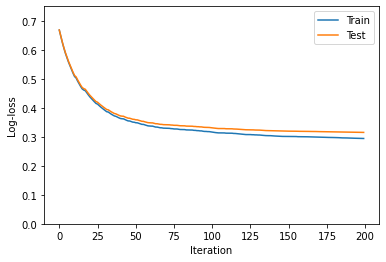

0.29430744693927813 0.315262441635687


In [50]:
# plot training rate
results = progress
epochs = len(results['train']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['train']['logloss'], label='Train')
ax.plot(x_axis, results['test']['logloss'], label='Test')
ax.legend()
plt.ylim(0, 0.75)
plt.xlabel("Iteration")
plt.ylabel("Log-loss")
plt.show()

print(results['train']['logloss'][-1], results['test']['logloss'][-1])

#fig.savefig("training_rate_pionproton_fhc.pdf", format="pdf")
#0.29448010289633453 0.3145504052416245

<Figure size 864x864 with 0 Axes>

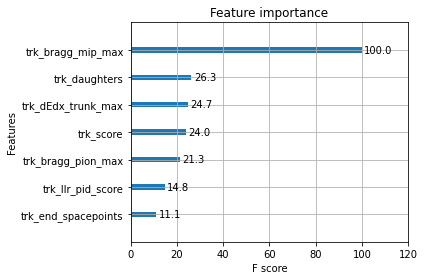

In [52]:
# plot importances
importance = bdt.get_score(importance_type="gain")

for key in importance.keys():
        importance[key] = round(importance[key],1)

# plotting importances of variables
plt.figure(figsize=(12,12),facecolor='white')
a = xgb.plot_importance(importance,max_num_features=20,importance_type='gain')
plt.xlim(0, 120)
plt.tight_layout()
#plt.savefig("feature_importance_pionproton_fhc.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

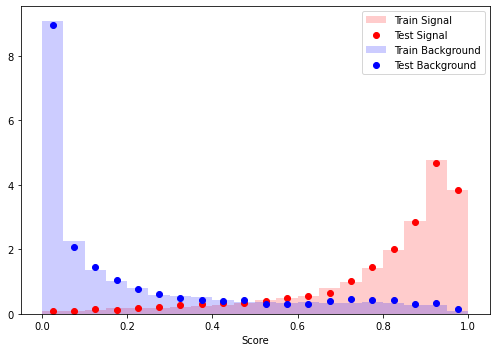

In [54]:
# plot test vs training
predictions_train_sig = bdt.predict(xgb_train_sig_dict)
predictions_train_bkg = bdt.predict(xgb_train_bkg_dict)
predictions_test_sig = bdt.predict(xgb_test_sig_dict)
predictions_test_bkg = bdt.predict(xgb_test_bkg_dict)

hist_range=[0,1.0]
n_bins=20

plt.figure(figsize=(7,5))
plt.hist(predictions_train_sig,bins=n_bins, range=hist_range, density=True,alpha=0.2,color='red',label='Train Signal' )
counts,bin_edges = np.histogram(predictions_test_sig,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers,counts,marker='o',linestyle="None",color='red',label='Test Signal')

plt.hist(predictions_train_bkg, bins = n_bins, range = hist_range, density = True, alpha = 0.2, color = 'blue', label = r'Train Background')
counts,bin_edges = np.histogram(predictions_test_bkg,bins = n_bins, range= hist_range,density = True)
bin_centers = (bin_edges[:-1] +  bin_edges[1:])/2.
plt.plot(bin_centers,counts,marker='o',linestyle ="None",color='blue',label = r'Test Background')
plt.legend()

plt.xlabel("Score")

plt.tight_layout()

#plt.savefig("performance_pionproton_fhc.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

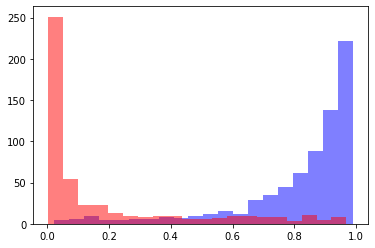

In [64]:
# create plot of predictions (testing samples)
num_bins = 20

plt.hist(predictions_test_sig, num_bins, color ='blue', alpha = 0.5)
plt.hist(predictions_test_bkg, num_bins, color ='red', alpha = 0.5)

plt.show()

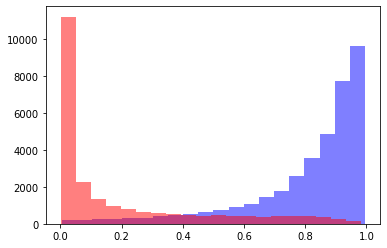

In [35]:
# create plot of predictions (training samples)
num_bins = 20
   
plt.hist(predictions_train_sig, num_bins, color ='blue', alpha = 0.5)
plt.hist(predictions_train_bkg, num_bins, color ='red', alpha = 0.5)

plt.show()

In [16]:
# Hyper parameter optimisation
# Un-tunded base case estimator to compare score
params_base = {'booster': 'dart',
               'objective': 'binary:logistic',
               'tree_method': 'hist',
               'rate_drop': 0.1,
               'skip_drop': 0.5,
               'scale_pos_weight': scale_weight,
               'random_state': 27}

base_model = xgb.train(params = params_base,
                       dtrain = xgb_train_dict,
                       num_boost_round = 300,
                       evals = [(xgb_test_dict,'eval')],
                       early_stopping_rounds=10,
                       verbose_eval = 20)

y_pred_base = base_model.predict(xgb_test_dict)

base_score = log_loss(df_test["isSignal"].values, y_pred_base)
print(base_score)

[0]	eval-logloss:0.55426
[20]	eval-logloss:0.30612
[40]	eval-logloss:0.30143
[55]	eval-logloss:0.30134
0.3011846763431571


In [17]:
# Simple Cross Val score as function to be optimised
def score(params):
    
    ps = {'eta': params['eta'],
         'max_depth': params['max_depth'], 
         'gamma': params['gamma'],
         'min_child_weight': params['min_child_weight'], 
         'subsample': params['subsample'], 
         'colsample_bytree': params['colsample_bytree'], 
         'verbosity': 1, 
         'objective': 'binary:logistic',
         'booster': 'dart',
         'eval_metric': 'logloss', 
         'tree_method': 'hist', 
         'rate_drop': 0.1,
         'skip_drop': 0.5,    
         'scale_pos_weight': scale_weight,
         'random_state': 27,
         }
    model = xgb.train(ps,xgb_train_dict, params['n_round'], [(xgb_test_dict, 'eval')], early_stopping_rounds=10, verbose_eval = False)
    y_pred = model.predict(xgb_test_dict)
    score = log_loss(df_test["isSignal"].values, y_pred)

    return score

In [18]:
# Define parameter space
param_space = {'eta': hp.uniform('eta', 0.01, 0.3), 
               'n_round': scope.int(hp.quniform('n_round', 100, 600, 50)),
               'max_depth': scope.int(hp.quniform('max_depth', 3, 5, 1)), 
               'gamma': hp.uniform('gamma', 0.5, 10), 
               'min_child_weight': hp.uniform('min_child_weight', 0.5, 10),
               'subsample': hp.uniform('subsample', 0.1, 1), 
               'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
              }


In [19]:
# Run optimiser with tpe
%time
trials = Trials()

hopt = fmin(fn = score,
            space = param_space, 
            algo = tpe.suggest, 
            max_evals = 250, ## 100
            trials = trials, 
           )

params_best = hopt
params_best['max_depth'] = int(hopt['max_depth'])
n_rounds_best = int(hopt['n_round'])
del params_best['n_round']
print(params_best)
print(n_rounds_best)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs
  0%|                                                                                                                                                                       | 0/250 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  0%|▌                                                                                                                                         | 1/250 [00:20<1:24:32, 20.37s/trial, best loss: 0.37882714204317985]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  1%|█                                                                                                                                          | 2/250 [00:31<1:02:01, 15.01s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  1%|█▋                                                                                                                                         | 3/250 [02:33<4:23:36, 64.03s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|██▏                                                                                                                                        | 4/250 [02:57<3:16:10, 47.85s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|██▊                                                                                                                                        | 5/250 [04:06<3:47:14, 55.65s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|███▎                                                                                                                                       | 6/250 [04:48<3:27:40, 51.07s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  3%|███▉                                                                                                                                       | 7/250 [05:19<2:59:44, 44.38s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  3%|████▍                                                                                                                                      | 8/250 [05:41<2:30:52, 37.41s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|████▉                                                                                                                                    | 9/250 [12:49<10:40:09, 159.38s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|█████▍                                                                                                                                  | 10/250 [21:22<17:54:39, 268.67s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|█████▉                                                                                                                                  | 11/250 [21:31<12:33:49, 189.25s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  5%|██████▌                                                                                                                                 | 12/250 [22:59<10:27:50, 158.28s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  5%|███████                                                                                                                                  | 13/250 [23:16<7:36:12, 115.49s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|███████▋                                                                                                                                  | 14/250 [23:26<5:28:31, 83.52s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|████████▎                                                                                                                                 | 15/250 [23:39<4:03:56, 62.28s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|████████▊                                                                                                                                 | 16/250 [23:58<3:12:04, 49.25s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  7%|█████████▎                                                                                                                               | 17/250 [27:55<6:51:07, 105.87s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  7%|█████████▉                                                                                                                                | 18/250 [29:17<6:21:09, 98.57s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|██████████▍                                                                                                                               | 19/250 [29:36<4:48:13, 74.86s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|███████████                                                                                                                               | 20/250 [29:50<3:36:07, 56.38s/trial, best loss: 0.3081756714313113]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|███████████▌                                                                                                                             | 21/250 [30:02<2:45:05, 43.26s/trial, best loss: 0.30569794693379826]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  9%|████████████▏                                                                                                                             | 22/250 [30:44<2:42:51, 42.86s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  9%|████████████▋                                                                                                                             | 23/250 [31:24<2:39:04, 42.05s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|█████████████▏                                                                                                                            | 24/250 [31:55<2:25:59, 38.76s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|█████████████▊                                                                                                                            | 25/250 [32:05<1:52:21, 29.96s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|██████████████▎                                                                                                                           | 26/250 [32:41<1:59:12, 31.93s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 11%|██████████████▉                                                                                                                           | 27/250 [33:13<1:57:50, 31.71s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 11%|███████████████▍                                                                                                                          | 28/250 [33:49<2:02:17, 33.05s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|████████████████                                                                                                                          | 29/250 [34:33<2:13:42, 36.30s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|████████████████▌                                                                                                                         | 30/250 [35:02<2:05:06, 34.12s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|█████████████████                                                                                                                         | 31/250 [35:11<1:37:13, 26.64s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 13%|█████████████████▋                                                                                                                        | 32/250 [35:23<1:20:46, 22.23s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 13%|██████████████████▏                                                                                                                       | 33/250 [35:45<1:20:32, 22.27s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|██████████████████▊                                                                                                                       | 34/250 [36:15<1:28:09, 24.49s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|███████████████████▎                                                                                                                      | 35/250 [36:50<1:39:22, 27.73s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|███████████████████▊                                                                                                                      | 36/250 [38:08<2:32:58, 42.89s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 15%|████████████████████▍                                                                                                                     | 37/250 [39:06<2:48:17, 47.40s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 15%|████████████████████▉                                                                                                                     | 38/250 [39:34<2:27:01, 41.61s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|█████████████████████▌                                                                                                                    | 39/250 [40:16<2:26:31, 41.67s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|██████████████████████                                                                                                                    | 40/250 [41:00<2:27:45, 42.22s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|██████████████████████▋                                                                                                                   | 41/250 [41:18<2:01:58, 35.02s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 17%|███████████████████████▏                                                                                                                  | 42/250 [41:53<2:01:49, 35.14s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 17%|███████████████████████▋                                                                                                                  | 43/250 [42:25<1:57:09, 33.96s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|████████████████████████▎                                                                                                                 | 44/250 [45:07<4:08:22, 72.34s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|████████████████████████▊                                                                                                                 | 45/250 [45:15<3:01:21, 53.08s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|█████████████████████████▍                                                                                                                | 46/250 [45:36<2:27:53, 43.50s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 19%|█████████████████████████▉                                                                                                                | 47/250 [46:43<2:51:07, 50.58s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 19%|██████████████████████████▍                                                                                                               | 48/250 [47:03<2:19:13, 41.35s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|███████████████████████████                                                                                                               | 49/250 [47:09<1:43:25, 30.88s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|███████████████████████████▌                                                                                                              | 50/250 [47:34<1:36:49, 29.05s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|████████████████████████████▏                                                                                                             | 51/250 [48:07<1:40:20, 30.25s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 21%|████████████████████████████▋                                                                                                             | 52/250 [48:52<1:54:07, 34.59s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 21%|█████████████████████████████▎                                                                                                            | 53/250 [49:10<1:37:42, 29.76s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|█████████████████████████████▊                                                                                                            | 54/250 [49:49<1:45:47, 32.39s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|██████████████████████████████▎                                                                                                           | 55/250 [49:56<1:20:44, 24.84s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|██████████████████████████████▉                                                                                                           | 56/250 [50:23<1:22:54, 25.64s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 23%|███████████████████████████████▍                                                                                                          | 57/250 [51:42<2:13:58, 41.65s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 23%|████████████████████████████████                                                                                                          | 58/250 [52:15<2:04:26, 38.89s/trial, best loss: 0.3015213312585303]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|████████████████████████████████▎                                                                                                        | 59/250 [53:20<2:29:05, 46.84s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|████████████████████████████████▉                                                                                                        | 60/250 [54:00<2:21:22, 44.65s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|█████████████████████████████████▍                                                                                                       | 61/250 [57:32<4:59:20, 95.03s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 25%|█████████████████████████████████▉                                                                                                       | 62/250 [58:12<4:05:58, 78.50s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 25%|██████████████████████████████████▌                                                                                                      | 63/250 [58:49<3:25:04, 65.80s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|███████████████████████████████████                                                                                                      | 64/250 [59:09<2:41:39, 52.15s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|███████████████████████████████████                                                                                                    | 65/250 [1:00:51<3:27:27, 67.29s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|███████████████████████████████████▋                                                                                                   | 66/250 [1:01:36<3:05:37, 60.53s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 27%|████████████████████████████████████▏                                                                                                  | 67/250 [1:02:22<2:51:10, 56.12s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 27%|████████████████████████████████████▋                                                                                                  | 68/250 [1:03:06<2:39:14, 52.50s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|█████████████████████████████████████▎                                                                                                 | 69/250 [1:03:41<2:22:35, 47.27s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|█████████████████████████████████████▊                                                                                                 | 70/250 [1:04:24<2:17:50, 45.95s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|██████████████████████████████████████▎                                                                                                | 71/250 [1:04:38<1:48:24, 36.34s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 29%|██████████████████████████████████████▉                                                                                                | 72/250 [1:04:57<1:32:44, 31.26s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 29%|███████████████████████████████████████▍                                                                                               | 73/250 [1:05:33<1:35:49, 32.48s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|███████████████████████████████████████▉                                                                                               | 74/250 [1:06:09<1:38:47, 33.68s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|████████████████████████████████████████▌                                                                                              | 75/250 [1:07:17<2:08:03, 43.91s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|█████████████████████████████████████████                                                                                              | 76/250 [1:07:37<1:46:28, 36.72s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 31%|█████████████████████████████████████████▌                                                                                             | 77/250 [1:07:59<1:33:03, 32.27s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 31%|██████████████████████████████████████████                                                                                             | 78/250 [1:08:11<1:15:41, 26.40s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|██████████████████████████████████████████▋                                                                                            | 79/250 [1:08:33<1:10:54, 24.88s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|███████████████████████████████████████████▏                                                                                           | 80/250 [1:09:24<1:33:12, 32.90s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|███████████████████████████████████████████▋                                                                                           | 81/250 [1:09:54<1:29:57, 31.94s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 33%|████████████████████████████████████████████▎                                                                                          | 82/250 [1:10:20<1:24:17, 30.10s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 33%|████████████████████████████████████████████▊                                                                                          | 83/250 [1:10:28<1:05:39, 23.59s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|█████████████████████████████████████████████▎                                                                                         | 84/250 [1:11:06<1:16:59, 27.83s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|█████████████████████████████████████████████▉                                                                                         | 85/250 [1:11:20<1:04:54, 23.60s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|██████████████████████████████████████████████▍                                                                                        | 86/250 [1:11:43<1:03:59, 23.41s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 35%|██████████████████████████████████████████████▉                                                                                        | 87/250 [1:12:22<1:16:20, 28.10s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 35%|████████████████████████████████████████████████▏                                                                                        | 88/250 [1:12:30<59:49, 22.16s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|████████████████████████████████████████████████▊                                                                                        | 89/250 [1:12:39<48:42, 18.15s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|████████████████████████████████████████████████▌                                                                                      | 90/250 [1:13:19<1:06:08, 24.80s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|█████████████████████████████████████████████████▏                                                                                     | 91/250 [1:13:39<1:01:40, 23.27s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 37%|█████████████████████████████████████████████████▋                                                                                     | 92/250 [1:14:19<1:14:32, 28.31s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 37%|██████████████████████████████████████████████████▏                                                                                    | 93/250 [1:16:09<2:18:12, 52.82s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|██████████████████████████████████████████████████▊                                                                                    | 94/250 [1:16:34<1:55:22, 44.38s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|███████████████████████████████████████████████████▎                                                                                   | 95/250 [1:20:20<4:15:38, 98.96s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|███████████████████████████████████████████████████▊                                                                                   | 96/250 [1:20:29<3:04:27, 71.86s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 39%|████████████████████████████████████████████████████▍                                                                                  | 97/250 [1:20:48<2:22:45, 55.99s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 39%|████████████████████████████████████████████████████▉                                                                                  | 98/250 [1:21:17<2:01:46, 48.07s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|█████████████████████████████████████████████████████▍                                                                                 | 99/250 [1:22:42<2:28:24, 58.97s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|█████████████████████████████████████████████████████▌                                                                                | 100/250 [1:23:49<2:33:47, 61.52s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|██████████████████████████████████████████████████████▏                                                                               | 101/250 [1:24:24<2:13:15, 53.66s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 41%|██████████████████████████████████████████████████████▎                                                                              | 102/250 [1:29:02<4:57:54, 120.77s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 41%|██████████████████████████████████████████████████████▊                                                                              | 103/250 [1:30:27<4:29:40, 110.07s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|███████████████████████████████████████████████████████▋                                                                              | 104/250 [1:30:48<3:23:01, 83.44s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|████████████████████████████████████████████████████████▎                                                                             | 105/250 [1:31:14<2:39:56, 66.18s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|████████████████████████████████████████████████████████▊                                                                             | 106/250 [1:31:42<2:11:25, 54.76s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 43%|█████████████████████████████████████████████████████████▎                                                                            | 107/250 [1:32:19<1:57:58, 49.50s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 43%|█████████████████████████████████████████████████████████▉                                                                            | 108/250 [1:32:37<1:34:42, 40.02s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|██████████████████████████████████████████████████████████▍                                                                           | 109/250 [1:32:57<1:19:35, 33.87s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|██████████████████████████████████████████████████████████▉                                                                           | 110/250 [1:33:14<1:07:38, 28.99s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|███████████████████████████████████████████████████████████▍                                                                          | 111/250 [1:34:51<1:54:30, 49.42s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 45%|████████████████████████████████████████████████████████████                                                                          | 112/250 [1:35:18<1:38:13, 42.71s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 45%|████████████████████████████████████████████████████████████▌                                                                         | 113/250 [1:36:42<2:05:39, 55.03s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|█████████████████████████████████████████████████████████████                                                                         | 114/250 [1:37:16<1:50:29, 48.75s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|█████████████████████████████████████████████████████████████▋                                                                        | 115/250 [1:37:24<1:22:01, 36.46s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|██████████████████████████████████████████████████████████████▏                                                                       | 116/250 [1:38:08<1:26:35, 38.77s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 47%|██████████████████████████████████████████████████████████████▋                                                                       | 117/250 [1:39:10<1:41:28, 45.78s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 47%|███████████████████████████████████████████████████████████████▏                                                                      | 118/250 [1:39:51<1:37:16, 44.21s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|███████████████████████████████████████████████████████████████▊                                                                      | 119/250 [1:39:59<1:12:45, 33.32s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|████████████████████████████████████████████████████████████████▎                                                                     | 120/250 [1:40:41<1:17:38, 35.84s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|████████████████████████████████████████████████████████████████▊                                                                     | 121/250 [1:41:14<1:15:18, 35.03s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 49%|█████████████████████████████████████████████████████████████████▍                                                                    | 122/250 [1:41:40<1:08:51, 32.28s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 49%|██████████████████████████████████████████████████████████████████▉                                                                     | 123/250 [1:41:47<52:43, 24.91s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|███████████████████████████████████████████████████████████████████▍                                                                    | 124/250 [1:42:05<47:56, 22.83s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|████████████████████████████████████████████████████████████████████                                                                    | 125/250 [1:42:13<38:21, 18.41s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|████████████████████████████████████████████████████████████████████▌                                                                   | 126/250 [1:42:41<44:00, 21.30s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 51%|█████████████████████████████████████████████████████████████████████                                                                   | 127/250 [1:43:01<42:23, 20.68s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 51%|████████████████████████████████████████████████████████████████████▌                                                                 | 128/250 [1:47:20<3:07:20, 92.13s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|█████████████████████████████████████████████████████████████████████▏                                                                | 129/250 [1:47:27<2:14:23, 66.64s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|█████████████████████████████████████████████████████████████████████▋                                                                | 130/250 [1:48:05<1:56:18, 58.15s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|██████████████████████████████████████████████████████████████████████▏                                                               | 131/250 [1:49:12<2:00:35, 60.80s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 53%|██████████████████████████████████████████████████████████████████████▊                                                               | 132/250 [1:49:23<1:30:17, 45.91s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 53%|███████████████████████████████████████████████████████████████████████▎                                                              | 133/250 [1:49:35<1:09:21, 35.57s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|███████████████████████████████████████████████████████████████████████▊                                                              | 134/250 [1:50:12<1:10:00, 36.21s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|█████████████████████████████████████████████████████████████████████████▍                                                              | 135/250 [1:50:29<58:02, 30.28s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|█████████████████████████████████████████████████████████████████████████▉                                                              | 136/250 [1:50:37<44:54, 23.64s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 55%|█████████████████████████████████████████████████████████████████████████▍                                                            | 137/250 [1:51:44<1:08:53, 36.58s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 55%|█████████████████████████████████████████████████████████████████████████▉                                                            | 138/250 [1:52:16<1:06:03, 35.38s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|██████████████████████████████████████████████████████████████████████████▌                                                           | 139/250 [1:53:48<1:36:59, 52.43s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|███████████████████████████████████████████████████████████████████████████                                                           | 140/250 [1:54:07<1:17:33, 42.30s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|███████████████████████████████████████████████████████████████████████████▌                                                          | 141/250 [1:55:23<1:35:18, 52.46s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 57%|████████████████████████████████████████████████████████████████████████████                                                          | 142/250 [1:56:22<1:37:39, 54.26s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 57%|████████████████████████████████████████████████████████████████████████████▋                                                         | 143/250 [1:56:30<1:12:00, 40.38s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|██████████████████████████████████████████████████████████████████████████████▎                                                         | 144/250 [1:56:37<53:50, 30.47s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|██████████████████████████████████████████████████████████████████████████████▉                                                         | 145/250 [1:56:54<46:15, 26.44s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|███████████████████████████████████████████████████████████████████████████████▍                                                        | 146/250 [1:57:12<41:25, 23.89s/trial, best loss: 0.30143788283667533]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 59%|████████████████████████████████████████████████████████████████████████████████▌                                                        | 147/250 [1:57:37<41:19, 24.07s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 59%|█████████████████████████████████████████████████████████████████████████████████                                                        | 148/250 [1:57:55<37:52, 22.28s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|█████████████████████████████████████████████████████████████████████████████████▋                                                       | 149/250 [1:58:32<45:01, 26.74s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 150/250 [1:58:49<39:55, 23.96s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|██████████████████████████████████████████████████████████████████████████████████▋                                                      | 151/250 [1:59:09<37:35, 22.78s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 61%|███████████████████████████████████████████████████████████████████████████████████▎                                                     | 152/250 [1:59:37<39:31, 24.19s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 61%|███████████████████████████████████████████████████████████████████████████████████▊                                                     | 153/250 [2:00:05<40:51, 25.27s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                    | 154/250 [2:00:25<38:00, 23.76s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|████████████████████████████████████████████████████████████████████████████████████▉                                                    | 155/250 [2:00:51<38:51, 24.54s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                   | 156/250 [2:01:09<35:04, 22.39s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 63%|██████████████████████████████████████████████████████████████████████████████████████                                                   | 157/250 [2:01:21<30:14, 19.51s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 63%|██████████████████████████████████████████████████████████████████████████████████████▌                                                  | 158/250 [2:01:39<29:01, 18.93s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|███████████████████████████████████████████████████████████████████████████████████████▏                                                 | 159/250 [2:02:05<31:48, 20.97s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                 | 160/250 [2:02:34<35:04, 23.38s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|████████████████████████████████████████████████████████████████████████████████████████▏                                                | 161/250 [2:02:46<29:34, 19.94s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 65%|████████████████████████████████████████████████████████████████████████████████████████▊                                                | 162/250 [2:03:06<29:22, 20.03s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                               | 163/250 [2:03:32<31:48, 21.93s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|█████████████████████████████████████████████████████████████████████████████████████████▊                                               | 164/250 [2:03:53<30:58, 21.61s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 165/250 [2:04:12<29:41, 20.96s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|██████████████████████████████████████████████████████████████████████████████████████████▉                                              | 166/250 [2:04:43<33:08, 23.67s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 67%|███████████████████████████████████████████████████████████████████████████████████████████▌                                             | 167/250 [2:04:56<28:29, 20.60s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 67%|████████████████████████████████████████████████████████████████████████████████████████████                                             | 168/250 [2:05:38<36:55, 27.02s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 169/250 [2:05:49<30:12, 22.37s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 170/250 [2:07:06<51:18, 38.49s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 171/250 [2:07:13<38:22, 29.14s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 69%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 172/250 [2:07:51<41:28, 31.90s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 69%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 173/250 [2:08:20<39:38, 30.89s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 174/250 [2:08:57<41:36, 32.84s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 175/250 [2:09:26<39:40, 31.74s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 176/250 [2:10:06<42:00, 34.06s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 71%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 177/250 [2:10:21<34:29, 28.35s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 178/250 [2:11:29<48:31, 40.44s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████                                       | 179/250 [2:11:47<39:35, 33.45s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 180/250 [2:12:27<41:17, 35.39s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 181/250 [2:12:39<32:51, 28.57s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 182/250 [2:12:59<29:14, 25.80s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 183/250 [2:13:39<33:43, 30.20s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 184/250 [2:13:58<29:38, 26.95s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 185/250 [2:14:04<22:25, 20.70s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 186/250 [2:15:10<36:24, 34.13s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 187/250 [2:15:36<33:25, 31.83s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 188/250 [2:16:04<31:41, 30.67s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 189/250 [2:16:22<27:05, 26.65s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 190/250 [2:17:22<36:49, 36.82s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 191/250 [2:17:30<27:30, 27.97s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 192/250 [2:18:31<36:43, 37.98s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 193/250 [2:19:05<34:59, 36.83s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 194/250 [2:19:42<34:19, 36.78s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 195/250 [2:20:12<32:04, 34.99s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 196/250 [2:20:19<23:55, 26.59s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 197/250 [2:21:19<32:17, 36.56s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 198/250 [2:21:40<27:32, 31.77s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 199/250 [2:22:07<25:54, 30.48s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 200/250 [2:22:27<22:40, 27.21s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 201/250 [2:22:35<17:32, 21.49s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 202/250 [2:22:54<16:39, 20.83s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 203/250 [2:23:33<20:32, 26.21s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 204/250 [2:23:49<17:45, 23.16s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 205/250 [2:23:57<13:57, 18.62s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 206/250 [2:24:26<15:49, 21.58s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 207/250 [2:24:52<16:26, 22.94s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 208/250 [2:25:15<16:04, 22.97s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 209/250 [2:26:38<27:59, 40.97s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 210/250 [2:27:13<26:05, 39.13s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 211/250 [2:27:39<22:53, 35.22s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 212/250 [2:28:19<23:10, 36.59s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 213/250 [2:28:48<21:17, 34.52s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 214/250 [2:29:06<17:37, 29.38s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 215/250 [2:29:24<15:14, 26.13s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 216/250 [2:29:45<13:56, 24.61s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 217/250 [2:30:44<19:12, 34.92s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 218/250 [2:31:26<19:40, 36.89s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 219/250 [2:31:47<16:40, 32.29s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 220/250 [2:32:23<16:39, 33.32s/trial, best loss: 0.3009561515487376]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 221/250 [2:33:20<19:32, 40.43s/trial, best loss: 0.3007515029595196]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 222/250 [2:34:01<18:56, 40.58s/trial, best loss: 0.3007515029595196]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 223/250 [2:34:39<17:59, 39.96s/trial, best loss: 0.3007515029595196]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 224/250 [2:37:30<34:14, 79.00s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 225/250 [2:43:13<1:05:58, 158.35s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 226/250 [2:49:50<1:32:00, 230.03s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 227/250 [2:51:56<1:16:11, 198.78s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 228/250 [2:54:26<1:07:31, 184.14s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 229/250 [2:58:40<1:11:43, 204.95s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 230/250 [3:04:14<1:21:13, 243.70s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 231/250 [3:07:34<1:13:05, 230.79s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 232/250 [3:10:39<1:05:02, 216.83s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 233/250 [3:11:43<48:30, 171.22s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 234/250 [3:14:51<46:57, 176.09s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 235/250 [3:15:42<34:37, 138.52s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 236/250 [3:17:07<28:34, 122.47s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 237/250 [3:18:13<22:53, 105.64s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 238/250 [3:22:45<31:07, 155.62s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 239/250 [3:26:17<31:37, 172.48s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 240/250 [3:34:33<44:54, 269.41s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 241/250 [3:39:39<42:04, 280.49s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 242/250 [3:40:47<28:52, 216.58s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 243/250 [3:48:12<33:16, 285.25s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 244/250 [3:53:12<28:58, 289.70s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 245/250 [3:59:03<25:40, 308.12s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 246/250 [4:02:25<18:24, 276.23s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 247/250 [4:04:34<11:35, 231.92s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 248/250 [4:06:16<06:26, 193.02s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 249/250 [4:10:48<03:36, 216.71s/trial, best loss: 0.29995507909162006]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [4:13:25<00:00, 60.82s/trial, best loss: 0.29995507909162006]
{'colsample_bytree': 0.8909238764061895, 'eta': 0.07037988768927586, 'gamma': 0.6546158826148706, 'max_depth': 5, 'min_child_weight': 5.324524463155783, 'subsample': 0.8312655958948683}
400
